# COMPSCI 527 Homework 4

Write the names of all contributors to this assignment here:

+ Haozhe Zhang
+ Philipe

## Part 1: Dimensionality Reduction

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import pickle
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import StandardScaler

In [2]:
def split_and_standardize(x, y, proportions=(6, 2, 2)):
    assert len(proportions) == 3, 'Need three numbers for proportions'
    for p in proportions:
        assert p >= 0., 'Proportions must be non-negative'
    s = float(sum(proportions))
    assert s != 0., 'Proportions cannot be all zero'
    ratios = [float(p) / s for p in proportions]
    test_ratio = ratios[2]
    assert test_ratio < 1., 'Cannot use all data for testing'
    if test_ratio > 0.:
        x_rest, x_test, y_rest, y_test = \
            train_test_split(x, y, test_size=test_ratio, random_state=0)
    else:
        x_rest, x_test, y_rest, y_test = x, None, y, None
    val_ratio = ratios[1] / (1. - test_ratio)
    assert val_ratio < 1., 'Need some data for training'
    if val_ratio > 0.:
        x_train, x_val, y_train, y_val = \
            train_test_split(x_rest, y_rest, test_size=val_ratio, random_state=0)
    else:
        x_train, x_val, y_train, y_val = x_rest, None, y_rest, None
    train_set = SimpleNamespace(x=x_train, y=y_train)
    val_set = None if x_val is None else SimpleNamespace(x=x_val, y=y_val)
    test_set = None if x_test is None else SimpleNamespace(x=x_test, y=y_test)
    scaler = StandardScaler()
    train_set.x = scaler.fit_transform(train_set.x)
    val_set.x = scaler.transform(val_set.x)
    test_set.x = scaler.transform(test_set.x)
    return SimpleNamespace(train=train_set, validate=val_set, test=test_set)

In [3]:
pickle_file = 'data.pkl'
try:
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    print('Done reading the MNIST data set from local file {}'.format(pickle_file))
except IOError:
    print('Fetching the MNIST data set from the web. This may take a while... ', end='')
    x, y = fetch_openml('mnist_784', return_X_y=True)
    data = split_and_standardize(x, y)
    print('Done.\nStoring the data locally to file {} for later reuse. '.format(pickle_file), end='')
    with open(pickle_file, 'wb') as file:
        pickle.dump(data, file)
    print('Done.')

Done reading the MNIST data set from local file data.pkl


In [4]:
from sklearn.linear_model import LogisticRegression

def train(train_set):
    np.random.seed(0)
    C = 50. / float(len(train_set.y))
    h = LogisticRegression(C=C, penalty='l1', solver='saga',
                           tol=0.01, multi_class='auto')
    h.fit(train_set.x, train_set.y)
    return h


def percent_accuracy(h, test_set):
    return h.score(test_set.x, test_set.y) * 100.


classifier = train(data.train)
baseline_accuracy = percent_accuracy(classifier, data.test)
fmt = 'Percent test accuracy of classifier on original data is {:.2f} percent'
print(fmt.format(baseline_accuracy))

Percent test accuracy of classifier on original data is 83.00 percent


### Problem 1.1

In [5]:
def projection_matrices(rows, columns):
    R_0 = [ [np.random.randn() for i in range(columns)]    for j in range(rows) ]
    R_0 = np.array(R_0)
    R = np.zeros((rows, columns))
    for i in range(columns):
        R[:, i] = R_0[:, i]/(np.linalg.norm(R_0[:, i]))
    U, s, vh = np.linalg.svd(R, full_matrices=False)
    return (U, R)

In [6]:
np.random.seed(0)
U, R = projection_matrices(10000, 4)
np.set_printoptions(precision=3)
print(R.T@R)

[[ 1.     0.014  0.004 -0.007]
 [ 0.014  1.     0.014 -0.009]
 [ 0.004  0.014  1.     0.011]
 [-0.007 -0.009  0.011  1.   ]]


I think the reason why R is already nearly orthonormal is because that we generate the matrix from independent normal distribution, thus the column vectors are highly likely to be quite uncorrelated with each other.

### Problem 1.2

In [7]:
max_power = 9
dims = np.logspace(0, max_power, max_power + 1, base=2).astype(int)

In [8]:
def project(sets_in, dimensions, seed=0):
    np.random.seed(seed)
    n = sets_in.train.x.shape[1]
    U, R = projection_matrices(n, dimensions)
    for ds in [sets_in.train, sets_in.validate, sets_in.test]:
        ds.x = np.matmul(ds.x, U)
        #ds.x = np.zeros((2,2))
    return sets_in

In [9]:
def percent_std_ratio(original_set, projected_set):
    std_orig = np.sqrt(np.sum(original_set**2))
    std_proj = np.sqrt(np.sum(projected_set**2))
    ratio = std_proj/std_orig
    return ratio*100

In [10]:
import copy

In [11]:
p_acc = []
p_stdratio = []
for d in dims:
    datac = copy.deepcopy(data)
    datacd = project(datac, d)
    h = train(datacd.train)
    percentacc = percent_accuracy(h, datacd.validate)
    percentstd = percent_std_ratio(data.validate.x, datacd.validate.x)
    p_acc.append(percentacc)
    p_stdratio.append(percentstd)
    

In [12]:
import matplotlib.pyplot as plt
hor = [83]*len(dims)

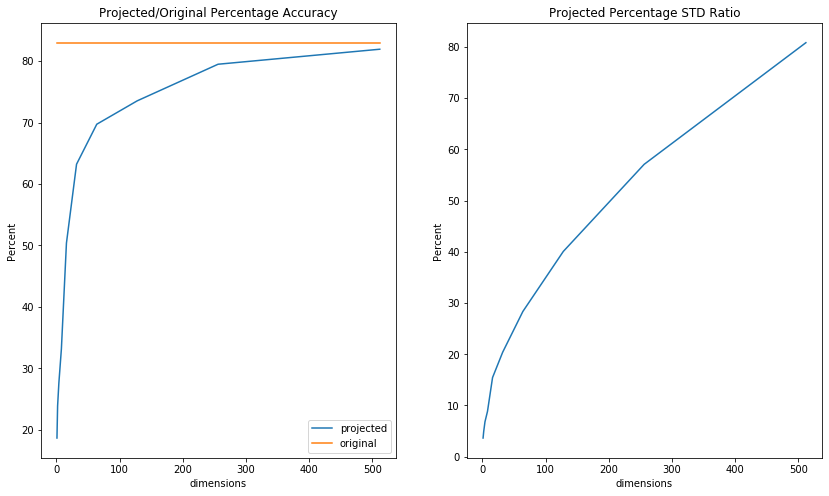

In [13]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize =(14,8))
axes[0].plot(dims, p_acc, label = 'projected')
axes[0].plot(dims, hor, label='original')
axes[0].set(title='Projected/Original Percentage Accuracy')
axes[0].legend()
axes[1].plot(dims, p_stdratio)
axes[1].set(title='Projected Percentage STD Ratio')
for axis in axes:
    axis.set(xlabel = 'dimensions', ylabel='Percent')

This dimensionality reduction technique definitely helps with the computational efficiency since we can see from the graph on the right that the projected percentage of standard deviation ratio drops significantly as we projected the original data into lower dimension.

However, it does not help with the quality of the classification results. Actually, we pay the price of a lower accuracy and this can be seen from the left plot that none of the projected accuracy is above the original one.

### Problem 1.3

In [14]:
from sklearn.decomposition import PCA

In [15]:
def pca_encoding(sets_in, dimensions):
    sets_out = copy.deepcopy(sets_in)
    pca = PCA(svd_solver='full', n_components=dimensions)
    sets_out.train.x = pca.fit_transform(sets_in.train.x)
    sets_out.validate.x = pca.transform(sets_in.validate.x)
    sets_out.test.x = pca.transform(sets_in.test.x)
    sinvals = pca.singular_values_
    return sets_out, sinvals

In [16]:
datacd, sinvals_overall = pca_encoding(datac, datac.train.x.shape[1])

In [17]:
from tqdm import tqdm

In [25]:
datacd, sinvals_overall = pca_encoding(datac, datac.train.x.shape[1])
total = np.sum(np.square(sinvals_overall))
p_acc_pca = []
p_stdratio_pca = []
p_stdratiofromsin = []
for d in tqdm(dims):
    datac = copy.deepcopy(data)
    datacd, sinvals = pca_encoding(datac, d)
    val = np.sum(np.square(sinvals))/total
    p_stdratiofromsin.append(val*100)
    h = train(datacd.train)
    percentacc = percent_accuracy(h, datacd.validate)
    percentstd = percent_std_ratio(data.validate.x, datacd.validate.x)
    p_acc_pca.append(percentacc)
    p_stdratio_pca.append(percentstd)

100%|██████████| 10/10 [02:52<00:00, 31.38s/it]


In [27]:
p_acc_pca

[28.749999999999996,
 33.52142857142857,
 59.285714285714285,
 75.42857142857143,
 82.7642857142857,
 84.74285714285715,
 84.85714285714285,
 84.87857142857142,
 84.87857142857142,
 84.87857142857142]

In [28]:
dims

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

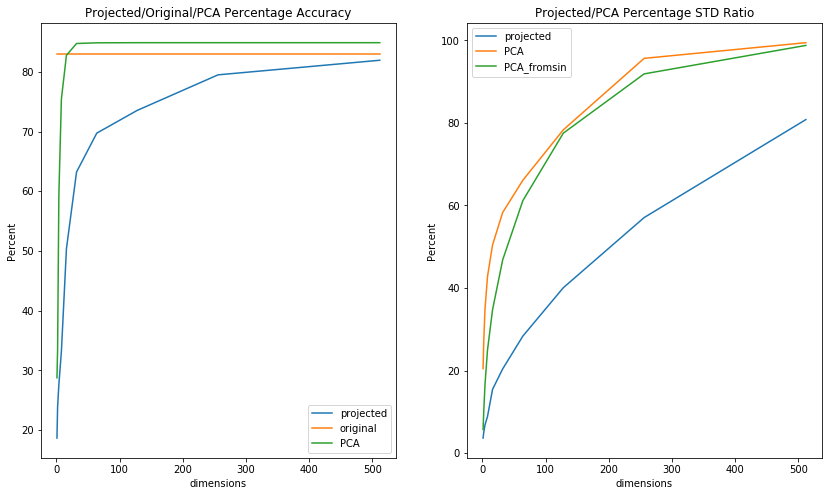

In [29]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize =(14,8))
axes[0].plot(dims, p_acc, label = 'projected')
axes[0].plot(dims, hor, label='original')
axes[0].plot(dims, p_acc_pca, label = 'PCA')
axes[0].set(title='Projected/Original/PCA Percentage Accuracy')
axes[0].legend()
axes[1].plot(dims, p_stdratio, label = 'projected')
axes[1].plot(dims, p_stdratio_pca, label = 'PCA')
axes[1].plot(dims, p_stdratiofromsin, label = 'PCA_fromsin')
axes[1].set(title='Projected/PCA Percentage STD Ratio')
axes[1].legend()
for axis in axes:
    axis.set(xlabel = 'dimensions', ylabel='Percent')

Apparently, this dimensionality reduction technique indeed help with the computational efficiency, since the ratio of standard deviaiton is pretty low when th dimension is small. It also surprisingly helps with the accuracy since it beats the benchmark(orginal) with higher values of d. 

From my results, dimensions 128, 256, 512 give the highest accuracy. Apparently, for computationally efficiency consideration, we will choose 128 and it indeed gives the best performance. 

The two ratio plots are more or less the same however not identical. This is because singular values are not exactly the standard varaiation, we actually need to normalize it. However, i did not normalize it. 

### Problem 1.4

In [30]:
from skimage.feature import hog

In [31]:
def hog_encoding(sets_in, orientations, pixels_per_cell, 
                cells_per_block, image_size = (28, 28)):
    sets_out = copy.deepcopy(sets_in)
    train =[]
    for i in range(sets_in.train.x.shape[0]):
        rows_train = hog(sets_in.train.x[i,:].reshape(image_size), orientations=orientations, pixels_per_cell = pixels_per_cell,
           cells_per_block = cells_per_block)
        train.append(rows_train)
    validate = []
    for i in range(sets_in.validate.x.shape[0]):
        rows_validate = hog(sets_in.validate.x[i,:].reshape(image_size), orientations=orientations, pixels_per_cell = pixels_per_cell,
           cells_per_block = cells_per_block)
        validate.append(rows_validate)
    test = []
    for i in range(sets_in.test.x.shape[0]):
        rows_test = hog(sets_in.test.x[i,:].reshape(image_size), orientations=orientations, pixels_per_cell = pixels_per_cell,
           cells_per_block = cells_per_block)
        test.append(rows_test)
    sets_out.train.x = np.array(train)
    sets_out.test.x = np.array(test)
    sets_out.validate.x = np.array(validate)
    return sets_out

In [32]:
datac = copy.deepcopy(data)

In [33]:
datac = copy.deepcopy(data)

In [34]:
A = hog_encoding(datac, 9, (2,2), (1,1))

In [35]:
h = train(A.train)

In [36]:
percentacc = percent_accuracy(h, A.test)

In [37]:
percentacc

60.30714285714286

In [38]:
dim = A.train.x.shape[1]

In [39]:
print(f"The test accuracy is {percentacc}")
print(f"The dimension of the HOG descriptor is {dim}")
print("The hyperparameters are: orientation = 9, pixels per cell = (2, 2), and cells per block = (1, 1)")

The test accuracy is 60.30714285714286
The dimension of the HOG descriptor is 1764
The hyperparameters are: orientation = 9, pixels per cell = (2, 2), and cells per block = (1, 1)


I actually don't think this technique help with the computational efficienty since HOG descriptor takes forever to run. Also, it did not help wiht the quality of the classification result either and this can be seen from the fact that we only achieve around 60 percent accuracy.

## Part 2: An Iterative Linear Solver 

### Problem 2.1

In [129]:
A = np.array([[5.0214, 0.8648], [8.6478, -0.5021]])
b = np.zeros(2)
z_0 = np.array([1., -1.])

In [130]:
import numpy as np


def make_f(A, b):
    def f(z):
        return np.linalg.norm(np.dot(A, z) - b, 2) ** 2
    return f

$$
\begin{align}
g(z) &= \nabla f(z) \\
 &= \nabla ||Az - b||^2\\
 &= \nabla (Az - b)'(Az-b) \\
 &= 2(Az -b)'A
\end{align}
$$

In [131]:
def make_g(A, b):
    def g(z):
        temp = A@z - b
        grad = 2*(temp.T@A)
        return grad
    zstar = np.linalg.lstsq(A, b)
    zstar = zstar[0]
    def plot_bowl(f, z_star, rect):
        x = np.linspace(rect[0], rect[1], 101)
        y = np.linspace(rect[2], rect[3], 101)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros((101, 101))
        for i in range(101):
            for j in range(101):
                Z[i,j] = f([X[i,j], Y[i, j]])
        fig = plt.figure()
        ax = plt.subplot(1, 1, 1)
        ax.axis(rect, 'scaled')
        ax.contour(X, Y, Z, 20, linewidths = 1, colors = 'grey')
        ax.plot(zstar[0], zstar[1], 'ro')
        return fig
    return g, plot_bowl

In [132]:
f = make_f(A, b)

In [133]:
g, plot_bowl = make_g(A, b)

C:\Users\hzhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


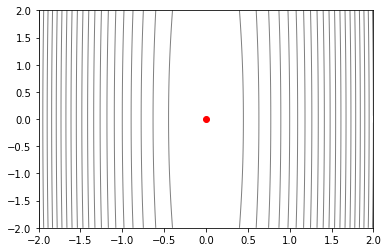

In [134]:
fig = plot_bowl(f, [0, 0], [-2, 2, -2, 2])

In [135]:
g(z_0)

array([199.997,  -1.999])

### Problem 2.2

In [136]:
from scipy import optimize


def line_search(f, g, z_0):
    f0, g0 = f(z_0), g(z_0)
    alpha = optimize.line_search(f, g, z_0, -g0, g0, f0)[0]
    return z_0 - g0 * alpha

In [137]:
def steepest(f, g, z_0, maxK=1000, delta = 1.e-8):
    h = [z_0]
    mse = 10
    k = 0 
    curr_z = z_0
    while mse > delta:
        if k < maxK:
            next_z = line_search(f, g, curr_z)
            h.append(next_z)
            k +=1 
            mse = np.linalg.norm(next_z - curr_z)
            curr_z = next_z
        else:
            break
    z = h[-1]
    return z, h

In [138]:
z, h = steepest(f, g, z_0)

In [139]:
z

array([-1.314e-09, -1.697e-07])

In [140]:
print(f'final answer {z}')
print(f'It has taken {len(h)} iterations')

final answer [-1.314e-09 -1.697e-07]
It has taken 117 iterations


In [141]:
def plot_history(h, f, z_star, rect):
    fig = plot_bowl(f, z_star, rect)
    h = np.array(h)
    plt.plot(h[:, 0], h[:, 1])
    plt.plot(z_0[0], z_0[1], 'bo')
    plt.show()
    return fig

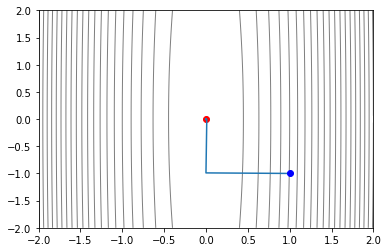

In [142]:
fig = plot_history(h, f, z, [-2, 2, -2, 2])

### Problem 2.3

In [143]:
P = np.zeros(A.shape)
P_inv = np.zeros(A.shape)
for i in range(A.shape[0]):
    P[i,i]= A[i,i]
    P_inv[i,i] = 1/(A[i,i])
B = np.matmul(A, P_inv)

In [144]:
np.linalg.cond(A)

10.0000279005852

In [145]:
np.linalg.cond(B)

1.0000888956644212

I think the smallest possible condition number that any matrix can have is 1. This is by definition since it's the ratio of the largest and smallest singular value. Clearly, the largest singular value is going to be at least as large as the smallest singular value.

### Problem 2.4

In [146]:
B = np.matmul(A, P_inv)

In [147]:
y_0 = P@z_0

In [148]:
f_B = make_f(B, b)
g_B, plot_bowl_B = make_g(B, b)

C:\Users\hzhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [149]:
y, h_y = steepest(f_B, g_B, y_0)

In [150]:
z = P_inv@y

In [151]:
print(z)

[-2.322e-15 -2.323e-13]


In [152]:
print(len(h_y))

4


In [153]:
print(f'The final solution here is {z}')
print(f'The number of iterations taken is {len(h_y)}')

The final solution here is [-2.322e-15 -2.323e-13]
The number of iterations taken is 4


In [154]:
h_z = []
for y in h_y:
    temp_z = P_inv@y
    h_z.append(temp_z)

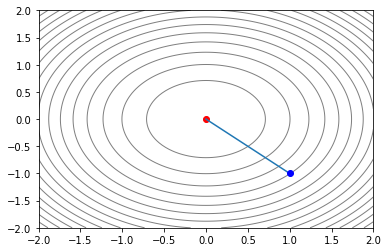

In [155]:
fig_b = plot_history(h_z, f_B, z, [-2, 2, -2, 2])

I do observe a significant improvement in number of steps, specifically 4 against 100 ish. This can also be seen from the plot. Descending through the diagonal is definitely faster than descending horizontally first then vertically like what they did before.

## Part 3: Miscellaneous Exam-Style Questions 

### Problem 3.1 (Exam-Style)

| Classifiers | Empirical Risk | Statistical Risk |
|-------------|----------------|------------------|
| {}          | 1/3            | 61               |
| {a}         | 2/3            | 56               |
| {b}         | 2/3            | 64               |
| {c}         | 0              | 49               |
| {d}         | 1/3            | 53               |
| {a, b}      | 1              | 59               |
| {a,c}       | 1/3            | 44               |
| {a,d}       | 2/3            | 48               |
| {b,c}       | 1/3            | 52               |
| {b,d}       | 2/3            | 56               |
| {c, d}      | 0              | 41               |
| {a,b,c}     | 2/3            | 47               |
| {a,b, d}    | 1              | 51               |
| {a,c,d}     | 1/3            | 36               |
| {b, c,d}    | 1/3            | 44               |
| {a,b, c, d} | 2/3            | 39               |

From the above table, we can clearly see that the empirically optimal classifiers are {c}, {c, d}. However, the statistically optimal classifier is {a,c,d}.

### Problem 3.2 (Exam-Style)

According to the bilinear voting technique proposed by the paper, it will contribute to the bins centered at 30 and 50. By the rule that it contributes to the bins in amounts inversely proportional to distance to cell centers and the orientation is 34 degress and maginitude is 40, we know it will contribute 32 to the bin centered at 30 and 8 to the bin centered at 50.

### Problem 3.3 (Exam-Style)

Let's first compute the gradient of $f(z) = \frac{x^2}{4} + \frac{y^2}{2}$. We get $\frac{\partial f}{\partial z} = (\frac{x}{2}, y)$. Then, we plug in (1,1) and get $\frac{\partial f}{\partial z} = (\frac{1}{2}, 1)$. Then the new point is $(1,1) + \alpha(\frac{1}{2}, 1) = (1+\frac{\alpha}{2}, 1 + \alpha)$.

Then, the line search is essentially minimize 
$$h(\alpha) = \frac{(1 + 0.5\alpha)^2}{4} + \frac{(1+\alpha)^2}{2}$$
Clearly, this function is convex so the minimum can be found via a first order condition. That is 
$$ 0.25 + 0.125\alpha + 1 + \alpha = 0$$
We get $\alpha^* = -\frac{10}{9}$. Then $z_1 = (\frac{4}{9}, \frac{-1}{9})$.

### Problem 3.4 (Exam-Style)

I think if we use Newton method instead, after one iteration $z_1 = (0, 0)$, which is actually the global minimum. The reason is that this function is already not only convex but also a second order polynomial. Thus, the second order Taylor expansion would just give back the original function, and the bottom of the second order Taylor expansion is just the bottom of the original function, which gives the global minimum.